# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**

**20/04/2020 - C8 S4**

## Manejo de Datos 2 y Visualización

Es Habitual que la información se encuentre dispersa en distintas fuentes y que por tanto, se requiera unificar el contenido. Si bien esto representa una componente importante del análisis de datos, el proceso no termina ahí, pues es necesario agregar, categorizar, agrupar y aplicar funciones a las agrupaciones logradas. Tales funciones se traducen en calculo de estadísticas, uso de tablas pivote, generación de visualizaciones entre otras tareas. 

En está cátedra, nos centraremos en las herramientas que facilitan los procesos de unificación, agrupación y visualización presentes en el flujo de trabajo de ciencia de datos. Tales herramientas se cimientan en `pandas` y `matplotlib`. 

## Primera Parte

### Unificación de _datasets_

La información contenida en los objetos `Series` y `DataFrame` puede ser combinada de distintas maneras. Una de ellas es por medio de *merging* o *fusión*, este tipo de operación permiten combinar *datasets* al enlazar filas según uno o más campos 'llave'. 

La función `merge` de pandas permite implementar estos procedimientos.

**Ejemplo**

Se generan 2 objetos `DataFrame` 

In [1]:
import pandas as pd
import numpy as np

df1 = pd.DataFrame({'llaves': list('abdabhakl'), 'data': range(9)})

# Se etiquetan los indices (ind) y columnas (columns)
df1.index.name = 'ind' 
df1.columns.name ='columns'

df1.sort_values(by = 'llaves', inplace=True)
df1

columns,llaves,data
ind,,
0,a,0
3,a,3
6,a,6
1,b,1
4,b,4
2,d,2
5,h,5
7,k,7
8,l,8


Se obtiene un nuevo dataframe por reindex del primero

In [2]:
df2 = df1.reindex(index = [1,3,5])

# Se alteran ciertos valores
df2.data = [10, 30, 50]

df2

columns,llaves,data
ind,,
1,b,10
3,a,30
5,h,50


En este caso se estudia la relación *muchos a uno* (*many to one*). Acá `df1` posee 3 instancias de la llave 'a' y 2 de 'b', por su parte `df2` posee solo una copia de cada 'llave'. Al utilizar `merge` sobre las llaves se obtiene:

In [3]:
pd.merge(df1, df2, on='llaves')

columns,llaves,data_x,data_y
0,a,0,30
1,a,3,30
2,a,6,30
3,b,1,10
4,b,4,10
5,h,5,50


En este caso tanto `df1` como `df2` comparten la columna `llaves` y merge procede a unificar ambos *datasets* utilizando la columna llave como punto de unión. Observe que se preservan los valores de `df1` en `data_x` y de `df2` en `data_y`. 

Si los dataframes a fusionar no poseen columnas en común, es posible entregar los argumentos `left_on` para la llave a utilizar en el dataframe izquierdo (como argumento de `merge`), de manera análoga se debe introducir `rigth_on`. 

Se crean dos nuevos dataframes sin columnas en común:

In [13]:
df3 = df1.copy()

# Se renombran las columnas
df3.rename(columns={'llaves': 'l_llave', 'data':'data_1'}, inplace=True)

# Se repite el proeso para df4
df4 = df2.copy()
df4.rename(columns={'llaves': 'r_llave', 'data':'data_2'}, inplace=True)

In [14]:
df3

columns,l_llave,data_1
ind,,
0,a,0
3,a,3
6,a,6
1,b,1
4,b,4
2,d,2
5,h,5
7,k,7
8,l,8


In [7]:
df4.head()

columns,r_llave,data_2
ind,,
1,b,10
3,a,30
5,h,50


Se procede a fusionar `df3` y `df4`:

In [8]:
pd.merge(df3,df4, left_on = 'l_llave', right_on= 'r_llave')

columns,l_llave,data_1,r_llave,data_2
0,a,0,a,30
1,a,3,a,30
2,a,6,a,30
3,b,1,b,10
4,b,4,b,10
5,h,5,h,50


Recuperando (salvo duplcación de llave) el dataframe anterior. `merge` opera por defecto haciendo uniones *internas* (*inner join*), esto significa, hay llaves en alguna dataset sin valor asociado en el otro, se omiten.

**Ejemplo**

Se comprueba lo anterior, para ello se agregan dos nuevas filas a `df3`. Observe que la opción `ignore_index` permite agregar diccionarios al final de `df3`

In [15]:
df3 = df3.append({'data_1': 100, 'l_llave': 'y'}, ignore_index=True)
df3 = df3.append({'data_1': 200, 'l_llave': 'z'}, ignore_index=True)
df3.tail(2)

columns,l_llave,data_1
9,y,100
10,z,200


Se repite el proceso de unión

In [18]:
pd.merge(df3, df4, left_on='l_llave', right_on='r_llave', how = 'inner')

columns,l_llave,data_1,r_llave,data_2
0,a,0,a,30
1,a,3,a,30
2,a,6,a,30
3,b,1,b,10
4,b,4,b,10
5,h,5,h,50


Lo que comprueba el resultado. 

**Ejercicio**

1. Utilice los objetos `DataFrame` `df3` y `df4` para explorar las opciones de `pd.merge(how = opt)` donde `opt` pertenece a `{'left', 'right', 'outer', 'inner'}`. 


El tipo de unión *muchos a muchos* (*many to many*).Se comporta de manera distinta. En este caso, se genera un producto cartesiano de las filas. 

**Ejemplo** 

Se agregan valores a `df4`, para ello se crea un dataframe con los valores a agregar, se declaran sus columnas y se agrega al final de `df4`. Observe la opción `ignore_index = True` esta permite omitir los índices de `df_pivot` y continuar con los de `df4`.

In [19]:
df_pivot = pd.DataFrame(
    [['a', 300], ['a', 301], ['h', 500], ['h', 501], ['b', 100]],
    columns=df4.columns)

# Observe que append en dataframes no opera como en listas (no es inplace)
df4 = df4.append(df_pivot, ignore_index=True)
df4.sort_values(by = 'r_llave', inplace=True)
df4

columns,r_llave,data_2
1,a,30
3,a,300
4,a,301
0,b,10
7,b,100
2,h,50
5,h,500
6,h,501


In [21]:
df3

columns,l_llave,data_1
0,a,0
1,a,3
2,a,6
3,b,1
4,b,4
5,d,2
6,h,5
7,k,7
8,l,8
9,y,100


In [22]:
df4

columns,r_llave,data_2
1,a,30
3,a,300
4,a,301
0,b,10
7,b,100
2,h,50
5,h,500
6,h,501


Se procede a unir `df3` con `df4`:

In [20]:
pd.merge(df3,df4, left_on='l_llave', right_on='r_llave', how= 'inner')

columns,l_llave,data_1,r_llave,data_2
0,a,0,a,30
1,a,0,a,300
2,a,0,a,301
3,a,3,a,30
4,a,3,a,300
5,a,3,a,301
6,a,6,a,30
7,a,6,a,300
8,a,6,a,301
9,b,1,b,10


Como hay 3 instancias de 'a' en `df3` y 3 instancias de 'a' en `df4`, se tienen un total de 9 entradas relacionadas a 'a' en la unión (desde el índice 0 al 8). Esto se puede interpretar de la siguiente manera: 

Cuando hay **una** columna de llaves, es decir, independiente del nombre de las columnas `left_on` y `right_on`, se escoge una por *dataset*. Se tendrá en este caso, que la  unión **muchos a muchos** repetirá los identificadores de la columna de llaves, tantas veces como lo requiera el producto cartesiano de los valores asociados a tales llaves. Por tal motivo, en el ejemplo anterior, aparecen 9 instancias de 'a'.

Por otra parte, `pd.merge()` permite la unión de *datasets* proporcionando **más de una** columna llave por *dataset*. En este caso, los identificadores a utilizar, pasan a ser elementos del producto cartesiano entre los identificadores de cada columna de llaves proporcionada, los cuales (identificadores), serán repetidos, tantas veces como el producto cartesiano de sus valores asociados lo requiera. 


**Ejemplo**

Se estudia la unión de _datasets_ *muchos a muchos* proporcionando múltiples  columnas de llaves. Para ello se definen los siguientes dataframes

In [23]:
df_m = pd.DataFrame({
    'llave_1': ['a', 'a', 'b'],
    'llave_2': [5, 7, 5],
    'data_m': [10, 20, 30]
})
df_m

,llave_1,llave_2,data_m
0,a,5,10
1,a,7,20
2,b,5,30


In [24]:
df_n = pd.DataFrame({
    'llave_1': ['a', 'a', 'b', 'b'],
    'llave_2': [5, 5, 5, 7],
    'data_n': [100, 200, 300, 400]
})
df_n

,llave_1,llave_2,data_n
0,a,5,100
1,a,5,200
2,b,5,300
3,b,7,400


Se procede a unir ambos *datasets*:

In [27]:
pd.merge(df_m,df_n, on = ['llave','llave_2'], how = 'outer')

,llave_1,llave_2,data_m,data_n
0,a,5,10.0,100.0
1,a,5,10.0,200.0
2,a,7,20.0,NaN
3,b,5,30.0,300.0
4,b,7,NaN,400.0


Al elegir `how = 'outer'` se realiza una *unión externa*, a diferencia de la unión interna, acá se agregan valores nulos cuando no se tiene la información (en vez de omitir la fila).


En este ejemplo se aprecia que el producto cartesiano entre `llave_1` y `llave_2` corresponde a: 

 * 'a',5
 * 'a',7
 * 'b',5
 * 'b',7
 
Se observa que para el par 'a',5  el producto cartesiano de sus valores asociados es:

* 10, 100
* 10, 200

mientras que para 'a',7 solo existe un valor en `df_m` y es nulo en `df_n`. Se continua con dicha lógica hasta completar la tabla.

**Ejercicios**

1. Cargue los datos `'data/timesData.csv'` en la variable `df` indexe por año y ranking,

2. Genere una función `data_process(df, year,n)` que procese al *dataset* `df` de manera tal, que retorne un sub-*dataset* con las primeras `n` universidades (según ranking), con las columnas 'university_name', 'teaching' y 'research'. Además debe tener un indice multinivel, donde 'country' sea el nivel más externo y 'wolrd_rank' se el nivel interno. *Hint*: Investigue el método `.set_index()`.

3. Utilice `data_process()` para generar datasets de los años 2011 y 2016 para `n=20` cada uno.

4. Haga una unión interna entre ambos *datasets* según los multiíndices, el resultado de esto le permitirá saber que universidades han mantenido su puesto, por país, al tiempo que puede verificar modificaciones en los puntajes de enseñanza e investigación. Observe que para esto deberá utilizar los argumentos `left_index` y `right_index`. Finalmente deduzca que la unión de *datasets* por indexación múltiple, obedece e mismo principio que la unión por múltiples columnas.

Otro tipo de unificación de datos es la concatenación, gracias a la indexación de pandas, es posible concatenar objetos con distintas indexaciones por medio de uniones internas (solo mantener datos ejes en común), elegir ejes de concatenación, concatenar *slices* de dataframes para componer otro, etc.

La función `pd.concat()` permite todo lo anterior y su funcionamiento es bastante intuitivo.

**Ejemplo** 

Se estudia la concatenación en series, para ello se definen `serie_1`, `serie_2` y `serie_3`.

In [28]:
serie_1 = pd.Series([1, 2, 3], index=list('abc'))
serie_2 = pd.Series([4, 5], index=list('cd'))
serie_3 = pd.Series([6, 7, 8, 9], index=list('efgh'))

`pd.concat()` actúa de la manera esperada en este caso

In [29]:
pd.concat([serie_1,serie_2,serie_3])

a    1
b    2
c    3
c    4
d    5
e    6
f    7
g    8
h    9
dtype: int64

Observe que se entrega una lista con las series como argumento. `pd.concat()` permite seleccionar eje de concatenación. En este caso, el valor por defecto es `join = 'outer`

In [34]:
# Se entrega el argumento sort=False para evitar un warning inocuo
pd.concat([serie_1, serie_2, serie_3], axis=1, sort=False, join = 'outer') 

,0,1,2
a,1.0,NaN,NaN
b,2.0,NaN,NaN
c,3.0,4.0,NaN
d,NaN,5.0,NaN
e,NaN,NaN,6.0
f,NaN,NaN,7.0
g,NaN,NaN,8.0
h,NaN,NaN,9.0


Si por otra parte se entrega el parámetro `join ='inner'`, se tendrá la intersección de las 3 series (que es nula).

In [35]:
pd.concat([serie_1, serie_2, serie_3], axis=1, sort=False, join='inner')

,0,1,2


Si por otra parte, solo se concatenan la series 1 y 2

In [36]:
pd.concat([serie_1, serie_2], axis=1, sort=False, join='inner')

,0,1
c,3,4


Se obtiene lo esperado, esto sugiere que se concatenan solo aquellas columnas donde no se deba insertar `NaN`.

**Ejercicios**

1. El argumento `keys` de la función `pd.concat()` permite crear un dataframe con multiíndices. Utilice las series `serie_1`, `serie_2` y `serie_3` y `keys` con el argumento `['s1', 's2, 's3']`. Observe que al concatenar por columnas, las llaves anteriores pasan a ser etiquetas de columna.

2. Utilice los dataframes `df_m` y `df_n` de la sección pasada. Utilice el parámetro `keys = ['df_m', 'df_n']`, genere un nuevo dataframe:
    1. Concatenando por fila para unión interna y externa. 
    2. Concatenado por columna para unión interna y externa
¿Como cambia el papel del parámetro `keys`?

En el caso de la concatenación de dataframes, se siguen los mismos patrones.

**Ejemplo**

Se crean 2 dataframes y se concatenan

In [37]:
df1 = pd.DataFrame(np.arange(1, 9).reshape(4, 2),
                   index=list('abcd'),
                   columns=['W', 'X'])
df1

,W,X
a,1,2
b,3,4
c,5,6
d,7,8


In [50]:
df2 = pd.DataFrame(10 * np.arange(4).reshape(2, 2),
                   index=['a', 'c'],
                   columns=['Y', 'Z'])
df2

,Y,Z
a,0,10
c,20,30


Se concatenan por filas:

In [52]:
pd.concat([df1, df2], axis = 0, sort=False)

,W,X,Y,Z
a,1.0,2.0,NaN,NaN
b,3.0,4.0,NaN,NaN
c,5.0,6.0,NaN,NaN
d,7.0,8.0,NaN,NaN
a,NaN,NaN,0.0,10.0
c,NaN,NaN,20.0,30.0


Se concatenan por columna:

In [53]:
pd.concat([df1, df2], axis=1, sort=False)

,W,X,Y,Z
a,1,2,0.0,10.0
b,3,4,NaN,NaN
c,5,6,20.0,30.0
d,7,8,NaN,NaN


Se concatenan usando columnas multinivel:

In [54]:
pd.concat([df1, df2], axis=1, sort=False, keys=['df1', 'df2'])

df1      df2      
    W  X     Y     Z
a   1  2   0.0  10.0
b   3  4   NaN   NaN
c   5  6  20.0  30.0
d   7  8   NaN   NaN

**Ejercicio**

1. Concatene `df1` y `df2` agregando un multiíndice con niveles superiores dados por `'df1_idx'` y `'df2_idx'`. 

2. Genere dos dataframes a partir de matrices aleatorias de dimensión 3 x 4 y 2 x 3. Agregue columnas, de manera tal que las etiquetas del segundo dataframe estén contenidas en las del primero. Concatene dichas matrices.  
Cuando se trabaja con dataframes, cuya información referente al indice no es relevante, se puede utilizar el argumento `ingnore_index = True`. Explore esta opción con los dataframes recién creados.

En alguna ocasiones puede ser útil reemplazar valores faltantes en un conjunto de datos, basándose en un segundo dataset. En este contexto, si hay coincidencia en índices y columnas, es posible 'parchar' información utilizando métodos de combinación de pandas. 

**Ejemplo**

Se crean 2 dataframes con información faltante, para eso se utilizan los dataframes `df_n` y `df_m`. En primer lugar, se definen las posiciones a alterar:

In [55]:
pos_m = [(1,1),(0,2),(2,2)]
pos_n = [(0,0),(0,2),(1,1),(2,1),(3,1)]

Se alteran de manera iterativa

In [56]:
for pos in pos_m:
    df_m.iloc[pos] = np.nan
for pos in pos_n:
    df_n.iloc[pos] = np.nan

Se muestran los cambios

In [57]:
df_m

,llave_1,llave_2,data_m
0,a,5.0,NaN
1,a,NaN,20.0
2,b,5.0,NaN


In [58]:
df_n

,llave_1,llave_2,data_n
0,NaN,5.0,NaN
1,a,NaN,200.0
2,b,NaN,300.0
3,b,NaN,400.0


Si se desea completar información en los espacios de `df_n` basándose en la información con mismos pares (índice,columna), la función `merge` no nos sirve

In [59]:
pd.merge(df_n,df_m, how = 'inner', left_index=True, right_index=True)

,llave_1_x,llave_2_x,data_n,llave_1_y,llave_2_y,data_m
0,NaN,5.0,NaN,a,5.0,NaN
1,a,NaN,200.0,a,NaN,20.0
2,b,NaN,300.0,b,5.0,NaN


De igual manera, concatenar (aunque sea con _inner join_) agrega filas o columnas a `df_n`

In [60]:
pd.concat([df_n,df_m],sort=False, join='inner', axis = 0)

,llave_1,llave_2
0,NaN,5.0
1,a,NaN
2,b,NaN
3,b,NaN
0,a,5.0
1,a,NaN
2,b,5.0


In [61]:
pd.concat([df_n,df_m],sort=False, join='inner', axis = 1)

,llave_1,llave_2,data_n,llave_1,llave_2,data_m
0,NaN,5.0,NaN,a,5.0,NaN
1,a,NaN,200.0,a,NaN,20.0
2,b,NaN,300.0,b,5.0,NaN


La correcta forma de añadir tal información es por medio del método `.combine_first()` y en conjunción con `.drop()`. En efecto, se 'parchan' los valores faltantes pero se agrega la columna `data_m`.

In [63]:
df_n

,llave_1,llave_2,data_n
0,NaN,5.0,NaN
1,a,NaN,200.0
2,b,NaN,300.0
3,b,NaN,400.0


In [64]:
df_m

,llave_1,llave_2,data_m
0,a,5.0,NaN
1,a,NaN,20.0
2,b,5.0,NaN


In [62]:
df_n.combine_first(df_m)

,data_m,data_n,llave_1,llave_2
0,NaN,NaN,a,5.0
1,20.0,200.0,a,NaN
2,NaN,300.0,b,5.0
3,NaN,400.0,b,NaN


Se elimina tal columna por medio de `.drop()`:

In [67]:
df_n.combine_first(df_m).drop('data_m', axis=1)

,data_n,llave_1,llave_2
0,NaN,a,5.0
1,200.0,a,NaN
2,300.0,b,5.0
3,400.0,b,NaN


Comparamos con `df_n` antes de combinar:

In [68]:
df_n

,llave_1,llave_2,data_n
0,NaN,5.0,NaN
1,a,NaN,200.0
2,b,NaN,300.0
3,b,NaN,400.0


Dada esta funcionalidad, es que hace importante tener consistencia en los indices y columnas de datasets con información relacionada. De esa forma, se puede simplificar el proceso de integración de bases y limpieza de datos.

#### Rearreglos

Dentro de las operaciones más comunes se encuentra el reordenado *reshape* de arreglos. En este contexto, existen las opciones `stack` y `unstack`. 

* `stack` permite utilizar las columnas como pivote. Genera un indexado jerárquico, moviendo las columnas al indexado como nivel inferior.

* `unstack` utiliza los indices como pivote. Genera un indexado jerárquico de columnas moviendo los indices al sector de columnas como nivel superior.

**Ejemplo**

Se define un dataframe con indexado jerárquico, se opera sobre el:

In [69]:
df_mi = pd.DataFrame(100 * np.arange(6).reshape((2, 3)),
                     index=['A', 'B'],
                     columns=['C1', 'C2', 'C3'])
df_mi

,C1,C2,C3
A,0,100,200
B,300,400,500


Se aplica `stack`, observe como se genera una "rotación" del dataframe:

In [73]:
df_mi.stack()

A  C1      0
   C2    100
   C3    200
B  C1    300
   C2    400
   C3    500
dtype: int64

Se aplica `unstack`, observe como rota en sentido opuesto a `stack`:

In [77]:
df_mi.unstack()

C1  A      0
    B    300
C2  A    100
    B    400
C3  A    200
    B    500
dtype: int64

**Ejercicio**

1. ¿Qué tipo de objeto se obtiene al realizar *stacking*?

El comportamiento en dataframes con multiindexado (en filas o columnas) consiste en pivotar sobre el nivel más interno, trasladándolo hacia filas o columnas nuevamente, posicionándolas en el nivel más interno.

**Ejercicio**

Para comprender el funcionamiento de `stack` y `unstack`, es más sencillo implementarlo. Para ello:

1. Defina un dataframe multiindexado. Para ello, concatene por columna resultado de ejecutar dos veces `df_mi.unstack()` por columna y asígnelo a la variable `df_s`. Ejecute `stack` y `unstack` sobre tal dataframe. **Obs:** Ambas ordenes son mutuamente inversas, por lo que concatenarlas siginifica no modificar el dataframe.

Como se vio, el comportamiento de `stack` y `unstack` de manera predeterminada es seleccionar los niveles más internos para pivotar. Se puede cambiar dicho comportamiento entregando un nivel. 

2. Genere un dataframe multi-indexando en filas y columnas. Para esto, ejecute:
    1. `df_s = pd.concat([df_s,df_s - 100], axis = 1)`
    2. `df_s = df_mi.unstack()`
    3. `df_s = pd.concat([df_s,df_s - 100], axis = 1)`
    4. `df_q = df_s.stack()`
    5. `df_q = pd.concat([df_q, df_q + 100, 0.2 * df_q], axis=1)`
    6. `df_q.columns = [['D1', 'D1', 'D2'], [1, 2, 3]]`

3. Ejecute `df_q.stack()` intente predecir su funcionamiento, repita el proceso con `df_q.unstack()`. ¿Se deberían introducir valores faltantes en alguno de estos casos?

4. Ejecute `df_q.stack({i})` donde `{i}` puede ser 0 o 1. ¿Qué representan estos números?

5. Ejecute `df_q.unstack({i})` donde `{i}` puede ser 0,1 o 2. ¿Qué representan estos números? ¿Por qué en este caso se puede llegar hasta 2?

6. Investigue le parámetro 'drop_na' de ambos métodos.

#### Agrupaciones 

La categorización de *dataset* facilita la exploración y transformación de los datos. Por lo general, los procesos de categorización y agrupamiento de *datasets* se ven envueltos en 3 *meta - procesos*: el primero es la *separación*, que corresponde a dividir un *dataset* en grupos basándose en *queries* o filtrado de algún tipo. Posteriormente se *aplica* (siguiente fase) alguna transformación a los componentes de la separación producida, para finalmente *combinar* (ultima fase) los resultados a un objeto final. 

**Ejemplo**

Se carga el *dataset* de ranking de universidades. 

In [78]:
df = pd.read_csv('data/timesData.csv', index_col=['year', 'world_rank'])
df.sort_index(inplace = True)

Se busca calcular el puntaje `total_score` promedio para las universidades en el primer puesto.

In [79]:
df.head(3)

university_name                   country  \
year world_rank                                                               
2011 1                         Harvard University  United States of America   
     10                           Yale University  United States of America   
     100         École Normale Supérieure de Lyon                    France   

                 teaching international  research  citations income  \
year world_rank                                                       
2011 1               99.7          72.4      98.7       98.8   34.5   
     10              92.1          59.2      89.7       91.5      -   
     100             51.1          37.6      34.4       88.8   26.1   

                total_score num_students  student_staff_ratio  \
year world_rank                                                 
2011 1                 96.1       20,152                  8.9   
     10                89.5       11,751                  4.4   
     100               57.0        2,218                  8.0   

                international_students female_male_ratio  
year world_rank                                           
2011 1                             25%               NaN  
     10                            20%           50 : 50  
     100                           14%           49 : 51

Para ello, es necesario limpiar la variable `total_score` pues es considerada como un valor 'string'. Esto ocurre pues posee valores faltantes denotados por '-'. 

In [81]:
# Se reemplazan los valores faltantes agregando NaN.
df['total_score'].replace('-',np.nan, inplace=True)
df['total_score'] = df['total_score'].apply(float)

# Se adquiere la media del puntaje, puede ser mejor reemplazar por knn
mean = df['total_score'].mean()

# Se llenan los valores faltantes
df.fillna(mean, inplace=True)

In [82]:
mean

59.846128226477944

In [83]:
df.head()

university_name                   country  \
year world_rank                                                               
2011 1                         Harvard University  United States of America   
     10                           Yale University  United States of America   
     100         École Normale Supérieure de Lyon                    France   
     101           Technical University of Munich                   Germany   
     102                   University of Helsinki                   Finland   

                 teaching international  research  citations income  \
year world_rank                                                       
2011 1               99.7          72.4      98.7       98.8   34.5   
     10              92.1          59.2      89.7       91.5      -   
     100             51.1          37.6      34.4       88.8   26.1   
     101             50.4          85.3      43.2       71.2      -   
     102             49.0          24.2      51.4       75.4   30.2   

                 total_score num_students  student_staff_ratio  \
year world_rank                                                  
2011 1                  96.1       20,152                  8.9   
     10                 89.5       11,751                  4.4   
     100                57.0        2,218                  8.0   
     101                56.9       35,565                 31.5   
     102                56.6       23,505                 15.1   

                international_students female_male_ratio  
year world_rank                                           
2011 1                             25%           59.8461  
     10                            20%           50 : 50  
     100                           14%           49 : 51  
     101                           20%           33 : 67  
     102                            6%           66 : 34

Posteriormente, se procede a agrupar `df` por ranking, es decir, los valores de ranking serán los indexadores para generar un nuevo dataframe. Esto se hace por medio del método `.groupby()`. En dataframes multiindexados, este método permite elegir el nivel sobre el cual se desea agrupar los datos. En este caso, el nivel correspondiente a 'world_rank' es 1. 

In [85]:
df.groupby(level=1)

El objeto resultante es una agrupación del tipo `DataFrameGroupBy`. Esta clase representa una regla de agrupación asociada a un objeto de pandas, sobre este tipo de agrupaciones, se puede realizar cálculos. 

Puede ser útil hacer una analogía entre los objetos `DataFrameGroupBy` y los iterators. Un iterator posee una regla de iteración que solo se aplica cuando se llama el método `__next__`, por su parte, un objeto `DataFrameGroupBy`representa una regla de agrupación, que se concreta cuando se aplica una transformación (agregación) sobre tal agrupación. 

Volviendo al ejemplo, no tiene sentido agrupar los valores por ranking si no se proporciona una regla de qué irá escrito en cada celda de la tabla, es decir, si no se proporciona un método de reducción, se tendrían que mostrar 6 valores distintos por celda, uno por cada año, para cada columna del dataframe. 

Finalmente, efectuamos la operación de agregación `.mean()` sobre la agrupación producida.

In [89]:
df.groupby(level=1).mean()

,teaching,research,citations,total_score,student_staff_ratio
world_rank,,,,,
1,95.650000,98.366667,99.616667,95.133333,7.233333
10,86.940000,91.800000,95.760000,89.020000,9.260000
100,42.225000,42.125000,76.925000,53.975000,26.136532
101,42.466667,45.766667,69.600000,54.933333,21.966667
102,42.140000,40.380000,80.980000,54.740000,13.920000
...,...,...,...,...,...
=82,45.250000,48.300000,84.150000,61.000000,15.000000
=88,54.050000,58.500000,64.650000,59.900000,12.250000
=90,46.533333,45.766667,87.066667,59.700000,9.800000


Si se desean obtener solo los resultados asociados a la columna 'total_score' ejecutamos `df['total_score'].groupby(level=1).mean()` para seleccionar solo el ranking 1, se ejecuta:

In [91]:
'''
Equivalente a 

df['total_score'].groupby(level=1).mean()[0] 

pues df['total_score'] es una serie!
'''

df['total_score'].groupby(level=1).mean().loc['1'] 

95.13333333333333

Si se quisiera agrupar por ranking y país de origen, se puede aplicar selección de columnas por medio de:

In [98]:
df.groupby(by = ['country','world_rank']).mean()

teaching  research  citations  \
country                  world_rank                                  
Argentina                601-800        16.00      9.00      12.50   
Australia                109            37.25     49.00      72.35   
                         114            38.80     50.10      58.00   
                         117            40.50     48.50      57.10   
                         152            49.50     48.90      51.20   
...                                       ...       ...        ...   
United States of America =65            53.50     61.00      88.00   
                         =90            49.95     41.85      89.95   
                         =94            54.40     39.30      82.50   
                         =99            47.30     52.60      76.80   
Unted Kingdom            401-500        18.40     20.40      51.90   

                                     total_score  student_staff_ratio  
country                  world_rank                                    
Argentina                601-800       59.846128            38.100000  
Australia                109           55.600000            23.300000  
                         114           51.700000            25.900000  
                         117           51.100000            40.500000  
                         152           51.200000            25.900000  
...                                          ...                  ...  
United States of America =65           65.900000            18.000000  
                         =90           59.700000             8.950000  
                         =94           58.800000             8.500000  
                         =99           58.000000            15.700000  
Unted Kingdom            401-500       59.846128            59.846128  

[1177 rows x 5 columns]

Observe que ahora 'world_rank' está contabilizado junto a las columnas por las cuales agrupar, aún cuando es un multiíndice.  

Si se quiere elegir solo el puntaje total, se debe tener en cuenta que el objeto resultante (posagregación) es un dataframe. Luego, se puede hacer lo siguiente:

In [ ]:
df.groupby(by = ['country','world_rank']).mean()['total_score']

**Ejercicio**

Es posible iterar sobre agrupaciones de datos

1. Genere una discretización de 'total_score' en 4 categorías: entre 0 y 25, entre 25 y 50, entre 50 y 75 y entre 75 y 100. Agregue tal discretización como una columna de nombre 'score_bin'.

2. Agrupe el conjunto de datos según año y score_bin. El objetivo se este ejercicio es que imprima en pantalla la información agrupada por año, extrayendo los nombres de sus universidades. Para ello:
    1. Itere con un ciclo for sobre la agrupación generada utilizando `i` como única variable de iteración. ¿Cuántas variables de iteración soporta la agrupación ? ¿por que?
    2. Imprima el intervalo inspeccionado por `i`.
    3. Imprima el nombre de la universidad para el país inspeccionado por `i`. Debería ser capaz de obtener en pantalla información de la forma:
    
    ```    
    Intervalo:  (25, 50] 

    year  world_rank
    2011  165                               University of Amsterdam
          165                               University of Liverpool
          167                                     Aarhus University
          168                                   University of Leeds
          168                                University of Würzburg
          170                               University of Groningen       
    ```
3. El método `.get_group()` de un objeto `DataFrameGroupBy` permite consultar por información similar a la impresa en pantalla. Ejecute la agrupación `df.groupby(by = ['year','score_bin'])` y luego aplique el método `.get_group((2011,intervalo))` donde intervalo es un objeto `pd.Interval` con valores adecuados para representar el intervalo '(25, 50]'.

**Obs**: Más allá de imprimir valores en pantalla, iterar sobre agrupaciones permite más flexibilidad de agregación sobre los datos agrupados, además de prestar herramientas para concatenación y generación de nuevos *datasets*.

Es posible agrupar por funciones o mapeos sobre los indices o columnas con las que queramos agrupar. 

Por ejemplo, si se desea añadir un nivel extra de agrupación sobre índices, es posible hacer con un *mapeo de relaciones*, este tiene la forma de un diccionario que permite emular el comportamiento de un índice multinivel, este puede ser utilizado en columnas con la opción `axis=1` o en índices con la opción de `axis` por defecto.

**Ejemplo**

Se define el mapeo dado por las relaciones:

* research, citations $\to$ desarrollo
* teaching, student_staff_ratio $\to$ docencia

Se hace por medio del diccionario:

In [ ]:
mapping = {
    'research': 'Desarrollo',
    'citations': 'Desarrollo',
    'teaching': 'Docencia',
    'student_staff_ratio': 'Docencia'
}

Se reconstruyen los índices para que los datos se agrupen por año y universidad

In [ ]:
df.reset_index(inplace=True)
df.set_index(['year','university_name'], inplace=True)
df.head(3)

Observe que se hace una agrupación en las columnas, por lo tanto si se desean ver resultados por año y ranking, es necesario agregar los datos por el eje `axis = 1`, en caso contrario, los valores presentes en la agrupación pasan a ser indices, como no se puede proporcionar un método de agregación al mapeo, esto resulta en un conjunto de indices vacío y por tanto en una agregación vacía.

In [ ]:
df[['teaching', 'research', 'citations', 'total_score',
    'student_staff_ratio']].groupby(mapping, axis=1).mean()

Se logra agrupar a las universidades por items de desarrollo y docencia, indexadas por año. 

**Ejercicio**

Una forma automática de generar mapeos es por medio de funciones, en este caso, el método `.groupby()` puede recibir una función $f(\cdot)$, esta función se aplica sobre los índices $i$ que formarán la nueva agrupación, generando nuevos índices de la forma $i_{mod} = f(i)$.

1. Defina la función `score_cat()`, esta función opera sobre una variable `score` de tipo `float` entre 0 y 100, retorna `'Buena'` si si `score < 75` y `Excelente` en caso contrario. 

2. Redefina el indice de `df` para que sea `'total_score'`. 

3. Genere una agregación por fila sobre las columnas numéricas de `df`,  de tal manera que los índices sean las categorías de puntaje total `Buena`, `Excelente` y que se muestre el promedio para cada categoría para las variables numéricas. *Hint*: Use `.groupby()` entregando como argumento la función `score_cat`, agregue por promedio.

Lo métodos `.sum()` , `.count()`, `.mean()`, `.std()` y `.var()` (entre otros) son agregaciones comunes implementadas por pandas. Todas forman parte de un método `.agg()`

**Ejemplo**

Se implementa una función propia de agregación, estas deben operar sobre arreglos y entregar un valor como resultado:

In [ ]:
def cos_agg(vec, phase=np.pi/2):
    '''Calcula la media de una transformacion coseno sobre vec.

    La transformacion es cos(phase*(vec**2)). 

    Args:
        vec: np.array, pd.Series
             Vector a transformar

        phase: numeric (opcional)
               Parametro de la transfromacion coseno  

    Returns:
        media: numeric
               Entrega el promedio de la transformacion coseno aplicada 
               componente a componente.
    '''
    return np.mean(np.cos(phase * vec ** 2))

Se forma un índice jerárquico basado en año y nombre de universidad

In [ ]:
df.reset_index(inplace=True)
df.set_index(['year', 'university_name'], inplace= True)

Se genera una agrupación por ranking y se agrega usando la función creada

In [ ]:
df.groupby('world_rank').agg(cos_agg)

`.agg()` acepta el nombre de una función como string (solo con funciones de agregación implementadas por default). Se agrupa por media

In [ ]:
df.groupby('world_rank').agg('mean')

Por otra parte, se puede proporcionar una lista de funciones, en formato string o puro. En tal caso se realiza una agregación por función entregada sobre el dataframe agregando un multinivel donde sea necesario

In [ ]:
df.groupby('world_rank').agg([cos_agg, 'mean'])

**Ejercicio**

Al proporcionar una lista de funciones para agregar, pandas asigna nombres de manera automática a los niveles de indexado. ¿Qué ocurre con las funciones anónimas (lambda)?

1. Defina una función anónima de agregación. Puede refactorizar la función `cos_agg` transformándola en función anónima por ejemplo.

2. Agregue los datos utilizando la función recién construida sobre la agrupación por `'world_rank'` realizada anteriormente. ¿Qué ocurre con el nombre de la columna multiindexada?

3. Entregue tuplas a `.agg` donde en la primera componente se entrega el nombre la columna a multiindexar, haga esto para su función anónima y para `'mean'`. Asignando los nombres 'cos_mean' y 'media' respectivamente.

4. Se pueden aplicar grupos de transformaciones por columna de agrupación, para ello se utilizan diccionarios de la forma `{'columna':'agregacion'}`. En la agrupación por `'world_rank` agregue los datos  `'teaching'`  por media y los de `'research'` por `cos_agg`.

5. Es posible tener múltiples agregaciones por columna, para eso se utilizan diccionarios de la forma:
```python
{'col_1': [func_11, func_21, ...,func_n1], 
 'col_2': [func_21, func_22, ...,func_n2],
     ...
 'col_m':[func_nm, func_nm, ...,func_nm]} 
```
Agregue la columna `'teaching'` por mínimo máximo y media, por otra parte agregue `'research'` por desviación estándar y `cos_agg`. ¿Cómo se pueden agregar nombres a estas agregaciones?

Como se discutió, los pasos del proceso de agregación consisten en separar, aplicar y combinar. `.groupby()` permite **separar** los datos generando un iterable sobre el cual se puede operar, `.agg()` **aplica** una función al objeto agrupado y finalmente los **combina** en un daframe. 

Si bien el comando de agregación `.agg()` presenta una gran flexibilidad en los procesos de *aplicación* y *combinación*, pandas ofrece una capa un poco más abstracta dada por el método `.apply()`. Este método *separa*, aplica y combina por medio de concatenación.

**Ejemplo**

Se trabaja con el dataframe anterior (ranking de universidades):

In [ ]:
df.head(3)

Supongamos que, a diferencia de agregar en un único valor (como lo hace la media por ejemplo) queremos obtener una lista ordenada de elementos por medio de una función, es posible definir una función para luego aplicarla sobre el dataframe.

En este caso, se buscan los mejores `n` puntajes, promediados por año, para una columna `col` determinada. Se desean mostrar los resultados por universidad, para ello, se define para ello la función `top_n_col()`.

In [ ]:
def top_n_col(df, n = 3, col = 'total_score'):
    '''Entrega los top n elementos de df.[col].'''
    
    # Agrupa por universidad y agrega por promedio
    grouped = df.groupby(level=1).mean()
    
    # retorna los mejores n valores para la columna deseada
    return grouped.sort_values(by = col)[-n:]

Se aplica la función al dataframe `df`

In [ ]:
top_n_col(df)

si se deseara agregar los resultados anteriores por país, se puede hacer utilizando la el método `.apply()` sobre una agrupación por país de `df`, en efecto

In [ ]:
df.groupby('country').apply(top_n_col)

Lo que hace `.apply()` en este caso es generar subdataframes para cada valor de la columna agrupada `'country'` en este caso, el primer subdataframe es el asociado a 'Argentina' y se accede a el por medio de:

In [ ]:
df[df['country'] == 'Argentina']

Si sobre aquel subdataframe *aplicamos* `top_n_col()` se observa el resultado de la primera fila anterior:

In [ ]:
top_n_col(df[df['country'] == 'Argentina'])

Luego, pasa al siguiente sub-dataframe (en este caso dado por 'Australia'), repite el calculo y concatena los resultados. Al recorrer cada valor de `'country'` termina generando el dataframe obtenido anteriormente.

**Ejemplo**

A continuación se estudia una aplicación de agregación de datos, esta consiste **en llenado de datos faltantes por grupo**. En primer lugar se carga la base de universidades.

In [ ]:
df = pd.read_csv('data/timesData.csv', index_col=['year','university_name'])
df.head(3)

Se estudian los valores nulos

In [ ]:
df.replace(to_replace='-', value=np.nan, inplace=True)

print('Porcentaje de valores faltantes')
(df.isnull().sum() / len(df))*100

Se observa que la columna `'total_score'` posee una alta cantidad de valores faltantes, por otra parte, las columnas `'income'` y `'female_male_ratio'` tiene menos de un 10% valores faltantes y 
`'num_students'`, `'international'`, `'student_staff_ratio'` e `'international_students'` tienen en torno al 2% de valores faltantes. Se forman 3 grupos.

El primer grupo será constituido por `'num_students'`, `'international'`, `'student_staff_ratio'` e `'international_students'`, la estrategia para llenar sus valores faltantes será por promedio. Para ello, es necesario convertir los datos a formato `'float'`. En el caso de `'num_students'` esto requiere un preprocesamiento.

In [ ]:
# Se reemplazan comas por puntos
df['num_students'].replace(',', '.', regex=True, inplace=True)

# Se transforman los datos a formato float
df['num_students'] = df['num_students'].apply(float)*1000

Para `'international_students'` se requiere transformar porcentajes a formato numérico

In [ ]:
# Se quitan los simbolos %
df['international_students'].replace('%', '', regex=True, inplace=True)

# Se transforman los datos a formato float
df['international_students'] = df['international_students'].apply(float)/100

Para 'female_male_ratio' es necesario transformar el formato `xx : yy` a porcentaje del tipo `xx/100`.  Para ello

In [ ]:
'''
Se busca un patron de la forma _:_xx y se elimina, aquí _ representa 
un espacio y se anota por \ , el simbolo : se mantiene y [0-9]*
representa numeros de la forma x_0 x_1 x_2, ..., x_n donde x_i 
representa un digito, la instrucción * dice repetir busqueda 
[0-9] (de digitos) hasta agotar el caracter inspeccionado.
'''

df['female_male_ratio'].replace('\ :\ [0-9]*', '', regex=True, inplace=True)
df['female_male_ratio'] = df['female_male_ratio'].apply(float)/100

Para el resto de las columnas no hay problema. Se procede a construir los grupos y se transforman los valores a formato numérico.

In [ ]:
groups = {
    'num_students': 'grupo_1',
    'international': 'grupo_1',
    'student_staff_ratio': 'grupo_1',
    'international_students': 'grupo_1',
    'income': 'grupo_2',
    'female_male_ratio': 'grupo_2',
    'total_score': 'grupo_3'
}

# Columnas a agrupar
cols = list(groups.keys())

# Transformación a datos flotanes
df[cols] = df[cols].applymap(float)

Se normalizan las variables para tener consistencia en los promedios

In [ ]:
df['international'] = df['international'] / 100

In [ ]:
H = df.copy()

In [ ]:
df = H.copy()

In [ ]:
#Para estas variables se decide normalizar por minimo y maximo 
def normalizer(vec):
    '''Normaliza por minimo y maximo al vector vec.'''
    
    m = vec.min()
    M = vec.max()
    
    return (vec - m)/(M-m)
    
df['student_staff_ratio'] = normalizer(df['student_staff_ratio'])
df['num_students'] = normalizer(df['num_students'])

Se procede a extraer las medias del grupo 1

In [ ]:
df[cols].groupby(groups, axis=1).mean()['grupo_1']

Para llenar los valores de este grupo, se genera la función `fill_mean` que llena los valores faltantes de un dataset utilizando su promedio. Esto en conjunción con `.apply()` permite llenar los valores faltantes para un grupo seleccionado.

In [ ]:
#Se extraen los elementos del grupo 1
grupo_1 = {key:val for key,val in groups.items() if val == 'grupo_1'}
grupo_1

Se crea la función `fill_mean`

In [ ]:
def fill_mean(df):
    return df.fillna(df.mean())

Se procede a llenar los valores faltantes:

In [ ]:
df[grupo_1.keys()].groupby(grupo_1, axis=1).apply(fill_mean)

**Ejercicio** 

1. Llene los valores faltantes de los otros dos grupos de variables, siguiendo un esquema de agregado diseñado por usted.

Por último, pandas ofrece una herramienta de *tablas pivote*, estas agregan los datos al proporcionar una o más llaves, generando un arreglo rectangular con llaves de agrupación en indices y columnas. 

Las tablas pivote se hacen por medio de `.groupby()` combinando indexación y reshaping. Estos métodos se resumen en la función `pd.pivot_table()` también disponible como el método `pivot_table`. 

**Ejemplo**

Se toma la base de ranking de universidades y se genera una tabla pivote proporcionando un indice jerárquico consistente de 'country' en el nivel superior y 'university_name' en el nivel inferior.

In [100]:
df.pivot_table(index = ['country', 'university_name'])

citations   research  \
country                  university_name                                        
Argentina                National University of Córdoba  12.500000   9.000000   
Australia                Australian National University  73.616667  72.383333   
                         Central Queensland University   43.700000  11.400000   
                         Charles Darwin University       61.080000  18.740000   
                         Curtin University               39.533333  16.533333   
...                                                            ...        ...   
United States of America Wayne State University          59.960000  15.540000   
                         William & Mary                  85.116667  22.250000   
                         Yale University                 94.616667  90.416667   
                         Yeshiva University              79.433333  28.666667   
Unted Kingdom            Aston University                51.900000  20.400000   

                                                         student_staff_ratio  \
country                  university_name                                       
Argentina                National University of Córdoba            38.100000   
Australia                Australian National University            19.200000   
                         Central Queensland University             29.600000   
                         Charles Darwin University                 25.400000   
                         Curtin University                         17.100000   
...                                                                      ...   
United States of America Wayne State University                    10.700000   
                         William & Mary                            11.800000   
                         Yale University                            4.400000   
                         Yeshiva University                         5.500000   
Unted Kingdom            Aston University                          59.846128   

                                                         teaching  total_score  
country                  university_name                                        
Argentina                National University of Córdoba     16.00    59.846128  
Australia                Australian National University     57.25    69.000000  
                         Central Queensland University      20.90    59.846128  
                         Charles Darwin University          17.92    59.846128  
                         Curtin University                  19.10    59.846128  
...                                                           ...          ...  
United States of America Wayne State University             33.64    59.846128  
                         William & Mary                     41.15    55.823064  
                         Yale University                    90.35    88.350000  
                         Yeshiva University                 49.35    50.416667  
Unted Kingdom            Aston University                   18.40    59.846128  

[820 rows x 5 columns]

Si en la tabla anterior se desea agregar los datos de 'total_score' se sigue la sintaxis:

In [ ]:
df['total_score'] = df['total_score'].replace('-', 'nan').astype(float)
df.pivot_table('total_score', index=['country', 'university_name'])

Si se desea hacer por puntaje total y puntaje de enseñanza

In [ ]:
df.pivot_table(['total_score', 'teaching'],
               index=['country', 'university_name'])

Es posible agregar cálculos por columna por medio de funciones de agregación, por defecto esta es el promedio. La opción a utilizar es `'margins'`.

In [ ]:
df.pivot_table(['total_score', 'teaching'],
               index=['country', 'university_name'], margins = True)

Para elegir otra función de agregación, se usa `aggfunc`. 

**Ejericio**

1. Genere una tabla pivote muliíndice donde la función de agregación sea la moda y se llenen los valores faltantes con el valor -1. 

Como fue enunciado anteriormente, `pivot_table` permite realizar agrupamientos tanto a nivel de índice como de columnas. Si queremos estudiar la evolución anual los puntajes `'research'` y `'teaching'` del conjunto de las universidades de cada país podemos utilizar:

In [ ]:
df.pivot_table(['research', 'teaching'], index='country', columns='year', aggfunc='mean')

**Ejercicio**  
1. Genere una tabla pivote similar a la anterior pero muestre la evolución anual, a nivel de país, de la **mediana** de los puntajes `'citations'` y `'total_score'`.

## Segunda Parte

### Elementos de Visualización en Python

Lograr visualizaciones (plots) informativas es de gran importancia en análisis de datos. Su aplicación en este campo es transversal, abarcando desde la parte exploratoria, para por ejemplo, identificación de outliers o búsqueda de transformaciones en las variables. Por otra parte, las visualizaciones son una manera natural de mostrar los resultados obtenidos y facilitar la interpretación de los fenómenos estudiados. En Python existen librerías capaces de producir visualizaciones de manera intuitiva tanto estáticas como dinámicas, en este ámbito, la librería raíz es `matplotlib`. Tal librería está diseñada para la creación de visualizaciones de alta calidad para publicaciones. 


`Matplotlib` puede exportar visualizaciones en formatos vectorizados y comprimidos como son PDF, SVG, JPG, PNG, GIF , entre otros. Existe una extensa variedad de librerías gráficas basadas en `matplotlib`, una de ellas es `seaborn`, la cual también se explora en este capítulo.

#### Importación y primeros pasos 

Como con NumPy y Pandas, existe una convención a la hora de importar esta librería:

In [1]:
import matplotlib.pyplot as plt

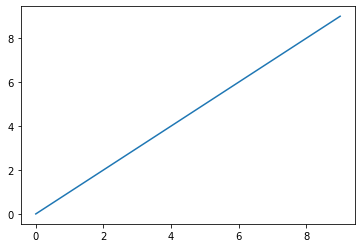

In [2]:
import numpy as np
data = np.arange(10)
plt.plot(data)

Para trabajar de manera interactiva, la linea mágica:
```
%matplotlib notebook

```
Toma provecho de las capacidades del proyecto Jupyter.

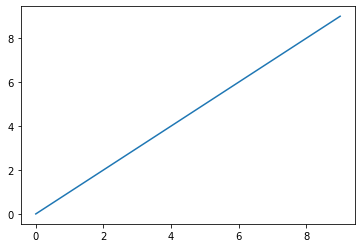

In [3]:

plt.plot(data)

#### Figuras y subplots

Las visualizaciones `plots` en matplotlib actúan dentro de un objeto más general denominado figura o `figure`. Es posible crear un objeto `figure` vacío para luego agregar las visualizaciones deseadas a través de:

```python
fig = plt.figure()

```
Esto genera una ventana vacía, no obstante, es posible modificar opciones del objeto `fig` declarado anteriormente. Dentro de estas opciones se encuentra `figsize` la cual permite indicar el tamaño y relación de aspecto al momento de almacenar la visualización en el disco.

Para insertar visualizaciones dentro de la figura recién creada, es necesario añadir un `subplot`, el método `add_subplot` permite agregar múltiples visualizaciones a la figura en la cual se invoca.

In [4]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

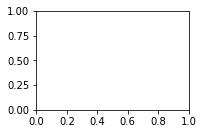

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)

El comando anterior indica que la figura tiene una estructura que comprende 2 visualizaciones por fila y 2 por columna, es decir la figura comprenderá 4 subfiguras de las cuales se selecciona la primera y se almacena como `ax1`.

**Ejercicio**

* Agregue 2 subfiguras a la figura `fig`. estas deben estar en la esquina superior derecha e inferior izquierda. Denote estas subfiguras como `ax2` y `ax3`.

Observación: En Jupyter, los plots se reinician luego de cada evaluación de celda, por lo tanto para obtener el esquema de subfiguras solicitado, debe declarar la figura y todos los subplots en la misma celda.

Al agregar un comando de visualización como por ejemplo:
```pyhton
plt.plot([-1,1,-1,1])
```
matplotlib modificará la última figura creada en su último subplot, en caso de ser una figura vacía, se creará un nuevo subplot en ella. Por lo tanto, al evaluar el código anterior, se deberá agregar una figura con forma de "N" en el último subplot del ejercicio anterior.

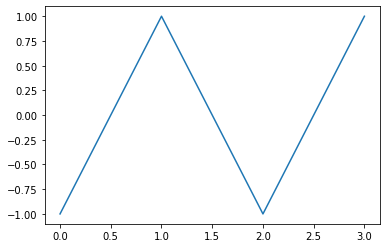

In [8]:
plt.plot([-1,1,-1,1])

Por otra parte, es posible añadir visualizaciones en los demás subplots usando las variables antes almacenadas:

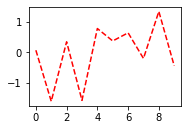

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.random.randn(10), 'r--')

En tal caso, se indicó generar el gráfico de una variable aleatoria normal estándar, de la cual se extraen 10 muestras. El comando `r--` indica que el gráfico debe ser rojo, con líneas "cortadas" y posicionado en el subplot `ax2`.

**Ejercicio**

* Genere un arreglo aleatorio de dimensión 100, explore con tal arreglo  el método `hist`. ¿Qué función cumple el parámetro `alpha`?

* Estudie el método `scatter`. ¿En qué se diferencia al método `plot`?


Otra manera de obtener figuras compuestas de subplots es a través del método `plt.subplots`, este entrega como `return` una figura y un arreglo NumPy con los objetos `subplot` en su interior:
```python
fig, axes = plt.subplots(2,3)
```

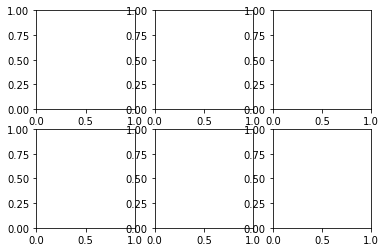

In [10]:
fig, axes = plt.subplots(2,3)

En cuanto a la variable `axes` esta presenta la facilidad de ser accedida como un arreglo de dos dimensiones, por ejemplo:

In [11]:
import numpy as np

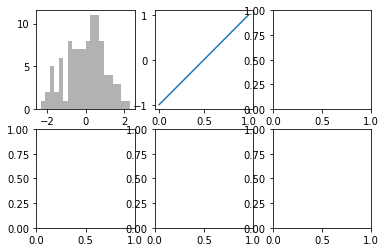

In [15]:
fig, axes = plt.subplots(2,3)

axes[0,1].plot([-1,1])
_ = axes[0,0].hist(np.random.randn(100), bins=20, color='k', alpha=0.3)


permite acceder al primer subplot de la segunda columna de la figura `fig`.

**Ejercicio**

* Utilice la notación anterior para graficar solo en los subplots correspondientes a la esquina inferior izquierda y esquina superior derecha.

* Una opción bastante útil es la de mantener la misma escala en cada subplot de la figura creada. Explore las opciones `sharex` y `sharey`. ¿Cómo se comporta matplotlib al no indicar estas opciones ?

#### Ajustes de espaciado en subplots

Por defecto, matplotlib maneja de manera automática el espacio alrededor de cada subplot. Esto se hace de manera relativa y en función a las dimensiones de la figura, sin embargo, es posible modificar esta opción utilizando `subplots_adjust` en objetos del tipo `Figure`:

```python
subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=None, hspace=None)
``` 

En este contexto, las variables `wspace` y `hspace` controlan el porcentaje de ancho (width) y alto (height) que se debe utilizar entre subplots. 

**Ejercicio**

* Genere una figura con 4 histogramas, todas las subfiguras deben estar adyacentes unas con otras (no debe haber espacio entre ellas). (Hint: genere los histogramas usando 2 ciclos `for` anidados)

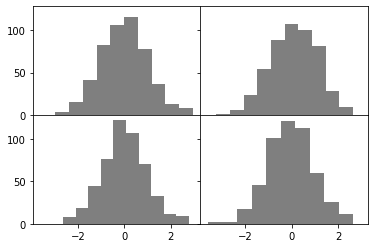

In [16]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        axes[i, j].hist(np.random.randn(500), color='k', alpha=0.5)
plt.subplots_adjust(wspace=0, hspace=0)

#### Colores, marcadores y estilos de línea

La función de visualización principal de matplotlib `plot` permite ingresar arreglos de coordenadas `x` e `y`, en este caso, para producir un gráfico color verde con líneas o "dashes" se puede ingresar un arreglo `X` y un arreglo `Y` ambos de la misma dimensión y ejecutar:

```python
ax.plot(X, Y, 'g--')
```

Donde `ax` es un subplot antes declarado. La notación anterior es una versión comprimida de las opciones `linesyle='--'` y `color='g'` de tal manera que el comando anterior equivale a ingresar:

```python
ax.plot(X, Y, linestyle='--', color='g')
```

**Ejericio** 

* Compruebe lo antes descrito.

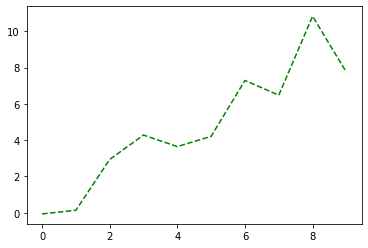

In [17]:
X = np.arange(10)
Y = X + np.random.randn(10)

fig = plt.plot(X, Y, linestyle='--', color='g')

En matplotlib es posible personalizar los colores que se desea obtener en un gráfico, los colores más usados poseen su propia abreviación por ejemplo `'g'` se refiere a verde, `'k'` a negro, `'r'` a rojo, etc ...

Si se desea ser aún más especifico, es posible ingresar un código hex para el color que se desea visualizar:

**Ejercicio**

* Cambie el color del gráfico anterior por uno en código hex de su elección.

Adicionalmente los plots pueden tener *marcadores* para resaltar las coordenadas correspondientes a los datos. Esto, debido a que la función `plot` genera una línea continua entre los puntos que se ingresan, por tanto, puede aparecer la necesidad de especificar las ubicaciones de los datos reales proporcionados. Los marcadores se acceden a través de la opción `marker` de la función `plot`, la siguiente [referencia](https://matplotlib.org/api/markers_api.htmlreferencia) proporciona los marcadores disponibles. Se puede acceder también a la notación simplificada utilizando por ejemplo:

```python
plt.plot(np.random.randn(30).cumsum(), 'ko-')
```
Donde el marcador es 'o' el color es negro y el tipo de línea es continuo.

In [ ]:
plt.plot(np.random.randn(30).cumsum(), 'ko-')

Como se puede observar, la interpretación entre los puntos del gráfico es hecha de manera lineal, esto se puede personalizar con la opción `drawstyle`, la siguiente [referencia](https://matplotlib.org/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_drawstyle) muestra los tipos de interpolación disponibles. 

En el siguiente ejemplo se especifica además la etiqueta o `label` de cada "línea" graficada:

In [ ]:
data = np.random.randn(30).cumsum()

plt.plot(data, 'ro--', label='Default')
plt.plot(data, 'k-' , drawstyle='steps-post', label='steps-post')
plt.legend()

Al final del ejemplo se ejecuta el comando `legend`, el cual indica que se de deben mostrar los objetos del tipo `label` declarados con la opción `label` en la función `plot`. En el caso de graficar sobre un subplot `ax` se puede llamar el método `ax.legend`.

#### Ejes, etiquetas y leyendas


Para personalizar los valores mostrados en el eje `x`, es posible usar las opciones `set_xticks` y `set_xticklabels`:

In [ ]:
# Genera una serie aleatoria

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.random.randn(500).cumsum())

# Selecciona los puntos de interes en el eje x
ticks = ax.set_xticks([0, 36,150, 225, 453])


# Cambia los nombres de los valores en el eje

labels = ax.set_xticklabels(['cero','A','B','X','W'], rotation=30, fontsize='large')

Es también posible agregar un titulo a la visualización, para ello se llama la función`set_title`:

In [ ]:
ax.set_title('Titulo de prueba')

**Ejercicio**

* Utilice el método `set_xlabel` para dar un nombre al eje `x` del plot anterior.


Modificar el eje `y` consiste en el mismo procedimiento antes descrito.

 Los objetos definidos por el método `add_subplots` se denominan `axes`, estos, como clase, poseen el método `set` que permite ingresar sus propiedades a través de un diccionario. En el caso anterior es posible configurar el subplot `ax` por medio de:


In [ ]:
ops = {
    'title':'Titulo de prueba',
    'xlabel':'Ejercicio'
}

ax.set(**ops)

Se debe indicar el diccionario antes descrito utilizando como llaves los campos que se deseen ingresar, además se debe utilizar doble asterisco `**` al llamar el método `set`, esto pues la declaración de tal método recibe un diccionario con variables "identificadas por nombre" como entrada. En declaración de funciones esto se denota con el uso de variables `**kwargs`.

#### Leyendas

Las leyendas corresponden al elemento principal de identificación de gráficos. Anteriormente se utilizó esta opción, en esta sección se estudia con más detalle.

La manera más sencilla de agregar una leyenda, cosiste en primero crear una etiqueta pasando la opción `label` al crear la visualización de interés para luego llamar el método `legend`.

In [ ]:
%matplotlib notebook 
from numpy.random import randn
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)

ax.plot(randn(100).cumsum(),'r'  , label='G_1')
ax.plot(randn(100).cumsum(),'k--', label='G_2')
ax.plot(randn(100).cumsum(),'g.-' , label='G_3')

ax.legend()

Como es de esperar, el método `legend` tiene opciones adicionales para, por ejemplo, controlar la posición de las legendas.

In [ ]:
ax.legend?

#### Anotaciones y figuras sobre un subplot

Hasta ahora, las visualizaciones generadas corresponden a figuras más bien estándar. En caso de querer agregar anotaciones adicionales, consistentes de texto, flechas u otras formas, es posible usar los métodos `text`, `arrow` y `annotate`. 

`text` genera un texto en las coordenadas (x,y) a elección, este método también presenta opciones extras sobre el estilo:

```python
ax.text(10,5,'Anotación Cepal', family='monospace', fontsize='10')
```

In [ ]:
ax.text(70,5,'Anotación Cepal', family='monospace', fontsize='10')

Las anotaciones pueden también dibujar flechas con texto informativo. 

Además de añadir anotaciones, es posible agregar figuras, las figuras principales se denominan `patches`, alguno de estos son los rectángulos y círculos, en la documentación de `matplotlib.patches` se hace una recopilación de estos. A continuación se muestra un ejemplo:

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
rect = plt.Rectangle((0.2, 0.75), 0.4, 0.15, color='k', alpha=0.3)
circ = plt.Circle((0.7, 0.2), 0.15, color='b', alpha=0.3)
pgon = plt.Polygon([[0.15, 0.15], [0.35, 0.4], [0.2, 0.6]],
color='g', alpha=0.5)
ax.add_patch(rect)
ax.add_patch(circ)
ax.add_patch(pgon)

#### Guardado de figuras

Es posible almacenar en el disco las figuras producidas, para ello, el método `plt.savefig` es usado. Por ejemplo, para almacenar una figura en formato `SVG` con el nombre `figura_text` se puede hacer con comando:
```python
plt.savefig('.../ruta/figura_test.SVG')

```

El tipo de archivo se infiere automáticamente de la extensión usada, los tipos de archivos soportados incluyen `png` y `pdf` entre otros. Algunas opciones de bastante utilidad son `dpi` y `bbox_inches`, el siguiente comando permite guardar un figura en formato `png` con 400 _dpi_ y con el mínimo espacio alrededor del gráfico:

```python
plt.savefig('figpath.png', dpi=400, bbox_inches='tight')
```

#### Configuración de matplotlib

El paquete descrito hasta acá viene preconfigurado con esquemas de colores. Todos estos esquemas "por defecto" pueden ser personalizados extendiendo los parámetros globales de la librería. El método `rc`  permite hacer esto, por ejemplo, para cambiar el tamaño de las figura a 10x10 se puede ingresar:

```python
plt.rc('figure', figsize=(10,10))
```

El primer argumento de `rc` es el componente que se desea personalizar, en este caso es `figure`, se puede acceder también a `axes`, `xtick`, `ytick`, `grid`, `legend` entre otros. Luego se ingresan los parámetros que se deseen modificar, esto puede ser hecho a través de diccionarios:

```python
opt = {'family' : 'monospace',
       'weight' : 'bold',
       'size' : 'small'}
plt.rc('font', **opt)
```

### Visualizaciones con Pandas y seaborn

`matplotlib` se puede interpretar como una herramienta de "bajo nivel" para la producción de visualizaciones, es decir, esta se generan a partir de sus componentes básicos.

En Pandas por otra parte, los DataFrames pueden tener múltiples columnas además de etiquetas para las filas. Este paquete posee métodos de visualización incluidos, pensados para simplificar el proceso de producción a partir de Series y DataFrames. 

Otra librería basada en tal principio es `seaborn`, esta corresponde a una librería de gráficos estadísticos construida sobre matplotlib. A continuación se estudian las posibilidades de visualización tanto en pandas como en seaborn.

#### Gráficos de línea

Las Series y Dataframes poseen atributo `plot`, este permite hacer gráficas simples, por defecto, este atributo genera gráficos de línea interpolados:

Se carga la base de ranking de universidades.

In [ ]:
df = pd.read_csv('data/timesData.csv', index_col=['year', 'university_name'])
df_to_plot = df.groupby(level=0).mean()

fig = plt.figure()
s = df_to_plot['research']
s.plot()

Los indices del objeto serie son interpretados como el eje `x`, esto se puede evitar con `use_index = False`. El los puntos de interés en `x` o _ticks_ y sus limites se pueden ajustar por medio de `xticks` y `xlim`, de la misma manera se puede ajustar el eje `y`. Las opciones disponibles se pueden acceder en la documentación del `plot`.

Por lo general, lo métodos de visualización en pandas permiten un parámetro `ax` el cual puede ser un subplot de matplotlib. 

El método `plot` en DataFrames genera un plot distinto para cada visualización produciendo una "línea" distinta por columna además de generar una leyenda de manera automática.

In [ ]:
df_to_plot.plot()

Por su parte, el método `plot` de un DataFrame, posee opciones diferentes a las de una Serie, siendo `subplots` una de estas:

In [ ]:
df_to_plot.plot(subplots=True)

#### Gráficos de barra

La función `plot.bar()` y `plot.barh()` generan gráficos de barra verticales y horizontales respectivamente. En esta caso, los índices ya sean de la Serie o DataFrame serán utilizados como el eje `x` (bar) o `y` (barh).

In [ ]:
fig, axes = plt.subplots(2, 1)
data = pd.Series(np.random.rand(16), index=list('abcdefghijklmnop'))

data.plot.bar(ax=axes[0], color='k', alpha=0.7)
data.plot.barh(ax=axes[1], color='k', alpha=0.7)

Las opciones `color = 'k'` y `alpha=0.7` proporcionan tanto el color como la transparencia de las barras.

In [ ]:
df = pd.DataFrame(np.random.rand(6, 4),

index=['one', 'two', 'three', 'four', 'five', 'six'],
columns=pd.Index(['A', 'B', 'C', 'D'], name='Titulo - personalizado'))

df.plot.bar()

Para crear gráficos de barra superpuestos a partir de un DataFrame la opción `stacked=True` lo permite de manera sencilla:

In [ ]:
df.plot.barh(stacked=True, alpha=0.9)

**Ejercicio** 

* Genere un gráfico de barras horizontal, donde se muestren las frecuencias para los puntajes promedio de 'research' separados en 5 bins. (Hint: `value_counts` con la opción bins)

Para hacer visualizaciones que requieran un agrupamiento previo exhaustivo de los datos, es posible usar `seaborn`:

In [ ]:
import seaborn as sns
fig=plt.figure()

sns.barplot(data=df_to_plot)

El argumento de barplot corresponde a un DataFrame u observaciones de una base de datos en arreglos `x` e `y`. En este caso, el gráfico corresponde a los valores promedio de los puntajes `'teaching'`, `'research'`, `'citations'` y `'student_staff_ratio'`. Además agrega un intervalo de confianza del 95% al valor (líneas negras).

Es posible cambiar el estilo de los gráficos usando el método `set` de seaborn:

In [ ]:
sns.set(style='whitegrid')

#### Histogramas y gráficos de densidad

Un histograma es un tipo de gráfico de barras que proporciona un valor discretizado de las frecuencias. Para esto, se discretizan los valores presentes en la base de datos para luego ser separados en "_bins_", posteriormente se gráfica el número de veces que un _bin_ es "poblado" por algún elemento de la base.

In [ ]:
df_to_plot.plot.hist(bins=50)

Un tipo relacionado de datos son los gráficos de densidad, estos calculan una estimación de la distribución de probabilidad que pudo haber generado los datos. El procedimiento usual para esto, es aproximar tal distribución por medio de una mezcla de "kernels", es decir, distribuciones más simples. Por tanto, los gráficos de densidad son conocido con el nombre de estimadores de densidad por kernels o KDE por sus siglas en ingles. Usando la función `plot.kde`  se puede obtener un KDE usando una mezcla de distribuciones normales:

In [ ]:
df_to_plot.plot.density()

Seaborn produce histogramas y gráficos de densidad de manera aún más sencilla a través del método `distplot`, el cual genera tanto un histograma como un KDE continuo (de manera simultanea). A modo de ejemplo, se consideran dos distribuciones conocidas:

In [ ]:
comp1 = np.random.normal(0, 1, size=200)
comp2 = np.random.normal(10, 2, size=200)
values = pd.Series(np.concatenate([comp1, comp2]))

In [ ]:
fig = plt.figure()
sns.distplot(values, bins=100, color='k')

#### Gráficos de dispersión

Los gráficos compuestos de "puntos" o gráficos de dispersión puede ser una manera útil de examinar la relación entre datos 2-dimensionales. Por ejemplo, en los datos analizados en la `clase 1` se hace uso de tal ventaja:

**Ejercicio**

* Utilice la función `sns.regplot()` sobre `df_to_plot['research']` como eje 'y' y `df_to_plot.index` como eje x.

Como pudo haber observado, tal función ajusta una regresión lineal sobre un gráfico de dispersión.

Otra herramienta importante en análisis de datos es la opción de analizar las relaciones entre las distintas variables que intervienen en el fenómeno que se estudia. Esto se puede hacer mediante el estudio de *gráficos de pares* o una **matriz de gráficos de dispersión**. Es posible generar gráficos de con tales características desde cero usando matplotlib, sin embargo, seaborn posee la función **pairplot** que soporta histogramas y KDE's de cada variable en la diagonal de la *matriz*.

In [ ]:
sns.pairplot(df_to_plot, diag_kind='kde')

Adicionalmente, es posible ingresar argumentos en forma de diccionario a través de la opción `plots_kws`, por ejemplo, si se quisiera agregar cierta transparencia: 
```python
sns.pairplot(arg_1, arg_2,...,plot_kws={'alpha': 0.2})
```

#### Grillas y datos categóricos

Una manera de visualizar datos con múltiples variables categóricas es usando un "grilla de facetas". En seabron existe la función `factorplot` que simplifica la tarea:

In [ ]:
# Se carga la base de ejemplo "tips" presente como
# dataset de ejemplo en seaborn.

tips = sns.load_dataset("tips")
tips['tip_pct'] = tips['tip'] / (tips['total_bill'] - tips['tip'])

sns.catplot(x='day', y='tip_pct', hue='time', col='smoker',
               kind='bar', data=tips[tips.tip_pct < 1])

En vez de agrupar por `time` usando colores distintos colores de barras, se puede expandir una "grilla de facetas" agregando una fila por valor de `time`:

In [ ]:
sns.factorplot(x='day', y='tip_pct', row='time', col='smoker',
                  kind='bar', data=tips[tips.tip_pct < 1])

In [ ]:
sns.catplot(x='day', y='tip_pct', row='time', col='smoker',
                  kind='bar', data=tips[tips.tip_pct < 1])

`catplot` soporta también otros tipos de gráficos que pueden ser útiles dependiendo de la que se desee mostrar. Por ejemplo los gráficos de caja:

**Ejercicio**

* Estudie el tipo de gráfico conocido como '*violin*'.